## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [68]:
def check_df(df):
    info_df = pd.DataFrame({
        'Tipo': df.dtypes,
        'No Nulos': df.count(),
        'Nulos': df.isnull().sum(),
        '% Nulos': (df.isnull().sum() / len(df)) * 100,
        'Memoria (MB)': df.memory_usage(deep=True).drop('Index') / 1024**2
    })
    return info_df


In [69]:
df = pd.read_csv("./data/credit_npo.csv")

#Hago mi propia función de .info() ya que la versión estándar muestra los datos desalineados dificultando su visualización.
display(check_df(df))


,Tipo,No Nulos,Nulos,% Nulos,Memoria (MB)
SeriousDlqin2yrs,int64,12537,0,0.000000,0.09565
RevolvingUtilizationOfUnsecuredLines,float64,12537,0,0.000000,0.09565
age,int64,12537,0,0.000000,0.09565
NumberOfTime30-59DaysPastDueNotWorse,int64,12537,0,0.000000,0.09565
DebtRatio,float64,12537,0,0.000000,0.09565
MonthlyIncome,float64,11816,721,5.750977,0.09565
NumberOfOpenCreditLinesAndLoans,int64,12537,0,0.000000,0.09565
NumberOfTimes90DaysLate,int64,12537,0,0.000000,0.09565
NumberRealEstateLoansOrLines,int64,12537,0,0.000000,0.09565
NumberOfTime60-89DaysPastDueNotWorse,int64,12537,0,0.000000,0.09565


Tenemos un dataset de 11 columnas, siendo cada una una característica financiera o demográfica, y 12537 registros, siendo cada fila una persona.

Explicación de cada columna:

- SeriousDlqin2yrs (int64)

    - Indica si la persona ha tenido dificultades financieras graves en los dos años posteriores mediante 0 y 1 (viéndose esto más adelante en el head()). 
    - Siendo 0 no tuvo problemas y 1 sí los tuvo.
    

- RevolvingUtilizationOfUnsecuredLines (float64)

    - Indica el porcentaje de crédito no garantizado que la persona está usando.


- age (int64)

    - Edad del cliente en años.


- NumberOfTime30-59DaysPastDueNotWorse (int64)

    - Número de veces que la persona ha tenido retrasos de entre 30 y 59 días en pagos, sin llegar a impago grave.
    - Siendo 0 nunca se ha retrasado y valores altos un comportamiento de pago poco fiable.


- DebtRatio (float64)

    - Relación entre deuda mensual y los ingresos.


- MonthlyIncome (float64)

    - Ingreso mensual de la persona. 
    - Esta columna tiene valores nulos y puede tener outliers muy grandes.


- NumberOfOpenCreditLinesAndLoans (int64)

    - Número total de créditos abiertos (tarjetas, préstamos personales, hipotecas, créditos al consumo, etc)


- NumberOfTimes90DaysLate

    - Número de veces que la persona se ha retrasado más de 90 días en pagos.
    - Siendo 0 un buen historial y más de 0 una señal clara de riesgo.


- NumberRealEstateLoansOrLines (int64)

    - Número de préstamos inmobiliarios (Hipotecas y créditos de carácter inmobiliario)


- NumberOfTime60-89DaysPastDueNotWorse (int64)

    - Número de retrasos de entre 60 y 89 días, sin llegar a 90.


- NumberOfDependents (float64)

    - Número de personas dependientes económicamente (hijos, personas a cargo)

In [70]:
#He descubierto esta forma de visualizar .describe(), transponiendo la matriz, y me parece más intuitiva a la hora de visualizar los datos
display(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,12537.0,0.068916,0.253321,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,12537.0,0.330359,0.368148,0.0,0.030651,0.163490,0.582219,6.0
age,12537.0,52.079445,15.077498,21.0,41.000000,51.000000,62.000000,101.0
NumberOfTime30-59DaysPastDueNotWorse,12537.0,0.409588,4.055787,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,12537.0,1.902253,9.122216,0.0,0.142268,0.302025,0.506725,99.0
MonthlyIncome,11816.0,6864.815420,11855.905437,0.0,3498.750000,5416.000000,8300.000000,702500.0
NumberOfOpenCreditLinesAndLoans,12537.0,8.482332,5.165422,0.0,5.000000,8.000000,11.000000,49.0
NumberOfTimes90DaysLate,12537.0,0.259312,4.035658,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,12537.0,0.999202,1.134325,0.0,0.000000,1.000000,2.000000,19.0
NumberOfTime60-89DaysPastDueNotWorse,12537.0,0.228364,4.018873,0.0,0.000000,0.000000,0.000000,98.0


Podemos ver por el .describe() lo siguiente: 

- Nuestras sospechas sobre los outliers en la columna MonthlyIncome se cumplen. Existen valores extremos muy altos, siendo el mínimo 0 y el máximo 702500. En la columna de DebtRatio también podemos observar posibles outliers. 
Esto puede influir negativamente en nuestros modelos.

- De MonthlyIncome podemos comentar que presenta una distribución asimétrica hacia la derecha observando la media y la mediana, 6864 y 5416, respectivamente. Además de valores mínimos de 0, podría corresponder a ausencia de ingresos.

- Las columnas de NumberOfTimes90DaysLate, NumberOfTime30-59DaysPastDueNotWorse y NumberOfTime60-89DaysPastDueNotWorse (las relacionadas con los retrasos) tienen gran cantidad de ceros. Siendo la mediana y el percentil 75 igual a 0. Esto significa que la mayoria de personas no se han retrasado nunca, muy pocos sí lo han hecho.


In [71]:
display(df.head(20))

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
5,0,0.101002,61,0,0.217115,15880.0,5,0,1,0,0.0
6,0,0.222830,60,0,0.907083,1312.0,5,0,0,0,0.0
7,0,0.353443,39,0,0.764309,4000.0,11,0,1,0,2.0
8,0,0.772455,45,0,0.387179,5100.0,5,0,1,0,3.0
9,0,0.116165,44,0,0.160236,10833.0,8,0,1,0,0.0


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Estamos tratando un problema de clasificación binaria supervisada. Siendo la variable target SeriousDlqin2yrs, ya que indica con 1 o 0 si la persona tendrá o no dificultades financieras.

In [72]:
target = "SeriousDlqin2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

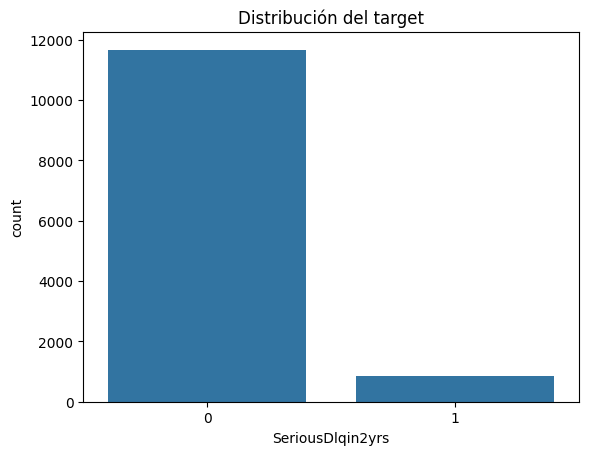

SeriousDlqin2yrs
0    0.931084
1    0.068916
Name: proportion, dtype: float64

In [73]:
sns.countplot(x=target, data=df)
plt.title("Distribución del target")
plt.show()

df[target].value_counts(normalize=True)

Es un dataset claramente desbalanceado, siendo la clase 1 la minoritaria.

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

Prepararemos los datos de la siguiente manera: separaremos X/y, trataremos los valores nulos, haremos train/test split y un escalado antes de pasar al modelado:

In [74]:
# Separación X / y
X = df.drop(target, axis=1)
y = df[target]


In [75]:
display(X.head())
display(y.head())

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


0    0
1    0
2    0
3    0
4    0
Name: SeriousDlqin2yrs, dtype: int64

In [76]:
# Tratamiento de valores nulos
X_noNull = X.copy()

display(X_noNull.head(5))

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [77]:
X_noNull["MonthlyIncome"] = X_noNull["MonthlyIncome"].fillna(X_noNull["MonthlyIncome"].median())
X_noNull["NumberOfDependents"] = X_noNull["NumberOfDependents"].fillna(0)

In [78]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_noNull, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [79]:
# Escalado
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN y regresión logística son sensibles a escala
# Random Forest no lo es, pero se mantiene consistencia


## Modelado

In [80]:
#Empezamos con un modelo de Regresión Logística como baseline
lr = LogisticRegression(max_iter=1000, class_weight="balanced")

scores_lr = cross_val_score(
    lr,
    X_train_scaled,
    y_train,
    scoring="recall",
    cv=5
)

recall_lr  = scores_lr.mean() 

print(recall_lr) 

0.7525492649358773


In [81]:
#Modelo KNN (sin optimizar)
knn = KNeighborsClassifier(n_neighbors=5)

scores_knn = cross_val_score(
    knn,
    X_train_scaled,
    y_train,
    scoring="recall",
    cv=5
)

recall_knn = scores_knn.mean()
print(recall_knn )

0.0969241997706183


In [82]:
#Ahora, optimizado
param_grid = {
    "n_neighbors": range(3, 21, 2),
    "weights": ["uniform", "distance"]
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    scoring="recall",
    cv=5
)

grid_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [83]:
best_knn = grid_knn.best_estimator_
best_recall_knn = grid_knn.best_score_

print(best_knn)
print(best_recall_knn)

KNeighborsClassifier(n_neighbors=3, weights='distance')
0.12877697841726618


In [84]:
#Modelo Random Forest

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

scores_rf = cross_val_score(
    rf,
    X_train,
    y_train,
    scoring="recall",
    cv=5
)

recall_rf  = scores_rf.mean()
print(recall_rf )

0.1302888124283182


In [85]:
resultados_recall = pd.DataFrame({
    "Modelo": [
        "Regresión Logística",
        "KNN (optimizado)",
        "Random Forest",
        "KNN (sin optimizar)"
    ],
    "Recall medio (CV)": [
        recall_lr,
        best_recall_knn,
        recall_rf,
        recall_knn
    ]
}).sort_values(
    by="Recall medio (CV)",
    ascending=False
)

display(resultados_recall)


,Modelo,Recall medio (CV)
0,Regresión Logística,0.752549
2,Random Forest,0.130289
1,KNN (optimizado),0.128777
3,KNN (sin optimizar),0.096924


Podemos observar los resultados de los recall medio que el modelo de Regresión Logística es el mejor modelo de forma aplastante con un 0.75. 

Random Forest sólo detecta un 13% de los clientes de riesgo, no sirve para el objetivo planteado a pesar de ser un modelo potente.

KNN falla, incluso optimizado, por: la cantidad de variables, teniendo estas muchos ceros dominantes, y las clases muy desbalanceadas. Al basarse en vecinos, la clase mayoritaria arrastra a la minoritaria.

Pasamos a optimizar la regresión logística, para ello empezamos cambiando el hiperparámetro C, que controla la regularización:

In [86]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100]
}

In [87]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced", #mantenemos el balanced para no perder recall
    random_state=42
)


Optimizamos usando GridSearchCV para mantener la coherencia metodológica.

In [88]:
grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1
)


In [89]:
grid_lr.fit(X_train_scaled, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring='recall')

In [90]:
print("Mejor C:", grid_lr.best_params_)
print("Mejor recall medio (CV):", grid_lr.best_score_)


Mejor C: {'C': 0.1}
Mejor recall medio (CV): 0.7525492649358774


Tras la optimización de los hiperparámetros de la regresión logística, el recall medio obtenido mediante validación cruzada se mantiene prácticamente idéntico al obtenido con los valores por defecto. Esto indica que el modelo ya se encontraba en un punto óptimo para la métrica priorizada y que la optimización no aporta mejoras adicionales. 

Se selecciona, aún así, el modelo resultante del proceso de optimización, aunque sus métricas no difieren del modelo base, lo que indica estabilidad del modelo.

In [91]:
best_lr = grid_lr.best_estimator_


In [92]:
#Entrenamiento final con todo el conjunto de entrenamiento
best_lr.fit(X_train_scaled, y_train)


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [93]:
#Evaluación sobre el conjunto de test
y_pred = best_lr.predict(X_test_scaled)


In [94]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_reports = pd.DataFrame(report_dict).T
display(df_reports)

,precision,recall,f1-score,support
0,0.974289,0.762741,0.855633,2335.000000
1,0.185294,0.728324,0.295428,173.000000
accuracy,0.760367,0.760367,0.760367,0.760367
macro avg,0.579791,0.745532,0.575530,2508.000000
weighted avg,0.919865,0.760367,0.816990,2508.000000


In [95]:
#Matriz de confusión y análisis de errores
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[1781  554]
 [  47  126]]


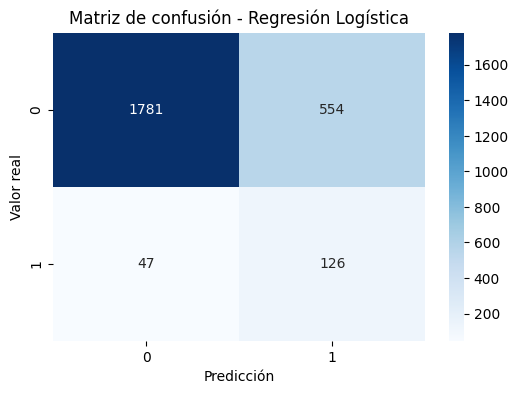

In [96]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión - Regresión Logística")
plt.show()


In [97]:
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
print(cm_norm)


[[0.7627409 0.2372591]
 [0.2716763 0.7283237]]


El modelo presenta una tasa moderada de falsos positivos, lo cual implica clasificar como riesgo a clientes que no lo son. Sin embargo, este comportamiento es aceptable, ya que permite reducir significativamente los falsos negativos, que suponen un mayor coste para el negocio al no detectar clientes con dificultades financieras.